# Large-scale QAOA via Divide-and-Conquer

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

[Quantum Approximation Optimization Algorithm](./QAOA_EN.ipynb) (QAOA) is a promising hybrid quantum-classical algorithm to solve combinatorial optimization problems approximately. However, its applicability is restricted by the qubit limitation for large-scale problems and its execution time scales exponentially with the problem size. Detailed and other limitations can be found in [1].

Divide-and-Conquer (DC) is a largely used technique to address similar challenges as those listed above, such as quicksort and fast Fourier transform (FFT). It recursively breaks down a problem into several subproblems of the same type until these subproblems can be solved directly.  

DC-QAOA proposed by Junde Li et al. in 2021 [2] applied such technique on QAOA to solve the Max-Cut problem. The methodology presented below adopts this DC-QAOA scheme with some modifications.

## Methodology

### Large Graph Partitioning (LGP)

Let $G(V,E)$ be an undirected graph with $n$ vertices and $k$ be the qubit (vertex) limit, i.e. available qubit size in NISQ computers. LGP partitions $G$ into exactly two subgraphs $G_0$ and $G_1$, and at least one node is shared between these two subgraphs so that no edges of $G$ are missed. Those shared nodes that enables this separation are separation nodes. Note that number of separation nodes should be smaller than the max qubit limit. 

The following code shown is to define such partition.

In [1]:
import networkx as nx # version of networkx >= 2.5
import matplotlib.pyplot as plt
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
# Partition a graph into two subgraphs
def NaiveLGP(g, k):
    E = list(g.edges)
    E = [(min([u, v]),max([u, v])) for (u, v) in E]
    E.sort(key = lambda tup:tup[0])
    V = list(g.nodes)
    V.sort()

    counter = 1
    while counter < k:
        num_nodes = counter
        nodes_combo = list(combinations(V, num_nodes))
        # Check suitable separation path
        for p in nodes_combo:
            V1 = [x for x in V if x not in p]
            E1 = [e for e in g.edges if e not in g.edges(p)]
            G1 = nx.Graph()
            G1.add_nodes_from(V1)
            G1.add_edges_from(E1)
            S = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]
            if len(S) == 2:
                # Add the separate paths to two subgraphs
                V_S0 = list(S[0].nodes)
                E_S0 = list(S[0].edges)   
                V_S1 = list(S[1].nodes)
                E_S1 = list(S[1].edges)
                for (u,v) in g.edges(p):
                    if u in V_S0 or v in V_S0:
                        S[0].add_edges_from([(u,v)])
                    if u in V_S1 or v in V_S1:
                        S[1].add_edges_from([(u,v)])
                    if u in p and v in p:
                        S[0].add_edges_from([(u,v)])
                        S[1].add_edges_from([(u,v)])

                return S

        counter += 1
    print("G has connectivity above k")

    return {}

One example for illustration is given below. The graph is a random with $10$ vertices and the qubit (vertex) limit is $9$ vertices. Then red vertices are those selected to be removed so that the rest is disconnected and can be partitioned. We then add separation nodes with incident edges back to these two subgraphs to avoid missing information of the graph. 

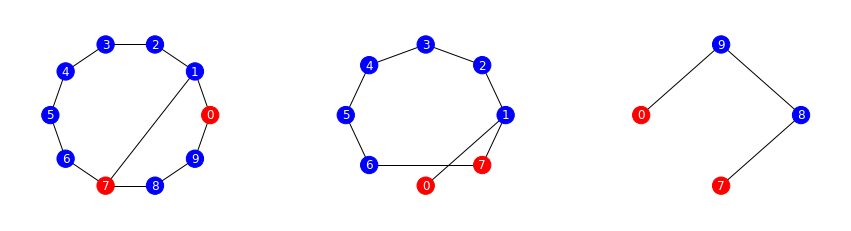

In [2]:
# Generate a connected graph with 10 vertices
n = 10
G = nx.Graph()
G.add_nodes_from([0,1,2,3,4,5,6,7,8,9])
G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(4,5),(1, 7),(5,6),(6,7),(7,8),(8,9),(9,0)])
    
k = 9 # Set qubit (vertex) limit
S = NaiveLGP(G,k) # Partition G into two subgraphs once
sep_node = list(set(S[0].nodes).intersection(set(S[1].nodes))) # Obtain seperation nodes of the partition

# Show graph illustration
options = {
    "with_labels": True,
    "font_color": "white"
}
node_color0 = ["red" if i in sep_node else "blue" for i in range(n)]
node_color1 = ["red" if list(S[0].nodes)[i] in sep_node else "blue" for i in range(len(S[0].nodes))]
node_color2 = ["red" if list(S[1].nodes)[i] in sep_node else "blue" for i in range(len(S[1].nodes))]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw_networkx(G, pos=nx.circular_layout(G), ax=ax[0], **options, node_color=node_color0)
nx.draw_networkx(S[0], pos=nx.circular_layout(S[0]), ax=ax[1], **options, node_color=node_color1)
nx.draw_networkx(S[1], pos=nx.circular_layout(S[1]), ax=ax[2], **options, node_color=node_color2)

Note that in our case, both subgraphs are under the qubit limit and can be directly solved by QAOA. But if the subgraph still exceeds the qubit limit, we will recursively do LGP through recursively doing DC-QAOA.

### Graph Reconstruction (GR)

Once QAOA is applied to partitioned subgraphs, we should combine the solutions for the parent graph. Note that since two partitioned subgraphs share some set of nodes, we need to make sure that the labeling sets which these nodes are in are consistent. For example, if in one subgraph, the shared nodes are all in $S_0$, while in the other subgraph, some of the shared nodes are in $S_0$ and some are in $S_1$. In this situation, corresponding solutions cannot be combined. So we provide several possible cuts for each partitioned subgraphs to avoid failure for the combination. 

In [3]:
def GR(str_cnt1, str_cnt2):
    com_cnt = []
    n = len(str_cnt1[0][0])
    com_index = []
    for i in range(n):
        if str_cnt1[0][0][i] != "x" and str_cnt2[0][0][i] != "x":
            com_index.append(i)
    
    for (str1, cnt1) in str_cnt1:
        for (str2, cnt2)  in str_cnt2:
            # Check equality for each bit in common nodes
            validity = [str1[i] == str2[i] for i in com_index]
            if False not in validity:
                com_str = [[0]] * n
                for i in range(n):
                    if str1[i] != "x":
                        com_str[i] = str(str1[i])
                    else:
                        com_str[i] = str(str2[i])
                com_cnt.append(("".join(com_str), min(cnt1, cnt2)))

    # Sort string-count map by counts in reverse order
    com_cnt.sort(key=lambda tup:tup[1])
    return com_cnt[::-1]

We still take the above example for illustration. For two subgraphs partitioned above, we apply QAOA to find their approximate max cuts and then use GR policy to form the max cut for the original graph. The code presented below has achieved this. Note that there is a parameter $t$ controlling how many possible cuts are kept, and if this $t$ is larger than $2^k$, all cuts are provided and the combination can definitely happen. 

In [5]:
# We use direct QAOA to compute approximate max cuts for two subgraphs
# In the next section, we will compute these using DC-QAOA because subgraphs might also exceed the qubit limit
import paddle
from paddle_quantum.QAOA.maxcut import find_cut

# Set QAOA parameters
p = 3 # Number of layers of QAOA circuit
ITR = 100 # Iterations of the training network of QAOA
LR = 0.5 # Learning rate in the training network of QAOA
# Set graph reconstruction parameter
t = 10 # Number of partition strings kept after graph reconstruction 
paddle.seed(999)  # Fix the seed

# Start graph reconstruction procedure
S_str_cnt = []
for si in S:
    siv = list(si.nodes)
    # Compute the subgraph's maxcut
    tmp, si_str_cnt_relabeled = find_cut(si, p, ITR, LR)
    # Make the subgraph's maxcut match the original graph by relabeling 
    si_str_cnt = []
    for str_relabeled in si_str_cnt_relabeled:
        strr = ""
        for i in range(len(G.nodes)):
            if i in siv:
                strr += str_relabeled[siv.index(i)]
            else:
                strr += "x"
        si_str_cnt.append((strr, si_str_cnt_relabeled[str_relabeled]))
    si_str_cnt.sort(key=lambda tup:tup[1])
    S_str_cnt.append(si_str_cnt[::-1][:t])

# Once we have already obtained max cut strings for two partitions, we perform the graph reconstruction (GR)
print("Max cut for the first partitioned subgraph: \n" + str(dict(S_str_cnt[0])))
print("Max cut for the second partitioned subgraph: \n" + str(dict(S_str_cnt[1])))
out_cnt = GR(S_str_cnt[0], S_str_cnt[1])
print("Combined max cut for the original graph: \n" + str(dict(out_cnt[:t])))

Max cut for the first partitioned subgraph: 
{'01010101xx': 0.07865689694881439, '10101010xx': 0.07865689694881439, '01101010xx': 0.0786568820476532, '10010101xx': 0.0786568820476532, '01010010xx': 0.04094248265028, '10101101xx': 0.04094248265028, '01011010xx': 0.04005919024348259, '10100101xx': 0.04005919024348259, '01010110xx': 0.04005918651819229, '10101001xx': 0.04005918651819229}
Max cut for the second partitioned subgraph: 
{'1xxxxxx010': 0.45565909147262573, '0xxxxxx101': 0.45565909147262573, '0xxxxxx011': 0.02522321417927742, '1xxxxxx100': 0.02522321417927742, '0xxxxxx110': 0.010825542733073235, '1xxxxxx001': 0.010825542733073235, '0xxxxxx111': 0.002283707959577441, '1xxxxxx000': 0.002283707959577441, '1xxxxxx011': 0.0022837070282548666, '0xxxxxx100': 0.0022837070282548666}
Combined max cut for the original graph: 
{'1010101010': 0.07865689694881439, '0101010101': 0.07865689694881439, '1010100100': 0.02522321417927742, '0101011011': 0.02522321417927742, '1010010100': 0.02522321

The top several possible max cuts for the first subgraph include {'01010101xx', '10010101xx', '01101010xx', '10101010xx'} and those for the second subgraph include {'0xxxxxx101,'1xxxxxx010'}, where 'x' indicates those missing nodes in the subgraph. From this example we see that the possible maximal cuts of separated vertices 0 and 7 in the first subgraph, '01010101xx', belong to $S_0$ and $S_1$, respectively. And they also belong to $S_0$ and $S_1$, respectively, in the maximal cut of the second subgraph, '0xxxxxx101'. so we can integrate these two maximal cuts and get the maximal cut of the original graph, ' 0101010101', as shown in the third diagram below.

Graph illustration is shown below. The left and middle subgraphs are subgraphs with approximate max cuts, where red and blue nodes represent $S_0$ and $S_1$ and dashed lines represent cuts.

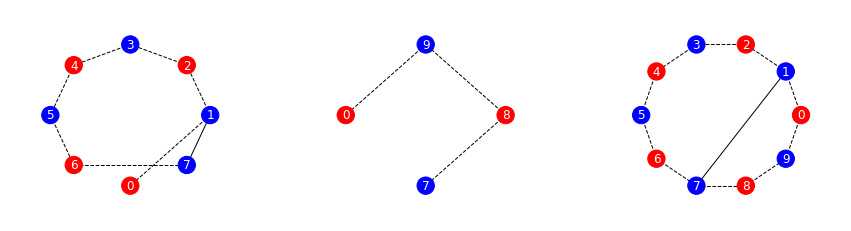

In [6]:
# Computed max cut for two subgraphs
strr1 =  '01010101xx'
strr2 = '0xxxxxx101' 
strr = '0101010101'

# Show graph illustration
options0 = {
    "node_color": ["red" if strr1[i] == '0' else "blue" for i in S[0].nodes],
    "style": ["solid" if strr1[u] == strr1[v] else "dashed" for (u, v) in list(S[0].edges)]
}
options1 = {
    "node_color": ["red" if strr2[i] == '0' else "blue" for i in S[1].nodes],
    "style": ["solid" if strr2[u] == strr2[v] else "dashed" for (u, v) in list(S[1].edges)]
}
options2 = {
    "node_color": ["red" if strr[i] == '0' else "blue" for i in range(n)],
    "style": ["solid" if strr[u] == strr[v] else "dashed" for (u, v) in list(G.edges)]
}

fig, ax = plt.subplots(1, 3, figsize=(15,4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw_networkx(S[0], pos=nx.circular_layout(S[0]), ax=ax[0], **options, **options0)
nx.draw_networkx(S[1], pos=nx.circular_layout(S[1]), ax=ax[1], **options, **options1)
nx.draw_networkx(G, pos=nx.circular_layout(G), ax=ax[2], **options, **options2)

### DC-QAOA

To find the max cut for a large graph with the number of vertices exceeding limits, DC-QAOA recursively divides it through LGP policy and conquers sub-solutions with GR policy described above. It adopts the divide-and-conquer paradigm to deal with the max-cut problem for large-scale graphs. 

The input graph is separated into exactly two subgraphs through LGP policy if the vertex size is larger than the qubit limit. Otherwise, its max cut would be directly calculated by QAOA. Each subgraph will recursively call DC-QAOA until its max-cut solution are returned, i.e. at some step, the vertex size of the subgraph is under the limit and can be directly processed by QAOA and returned values would be combined and then be given to the upper layer. 

The code below provides the way to run DC-QAOA and LGP and GR policies are both applied in the `DC_QAOA` function. Note that QAOA would return a series of possible cuts, sorted by frequency count.   

In [7]:
def DC_QAOA(g, p, t, s, k, ITR, LR):
    if len(g.nodes) > k:
        # get exactly two subgraphs with LGP policy
        S = NaiveLGP(g, k)

        S_str_cnt = []
        for si in S:
            siv = list(si.nodes)
            # Compute the subgraph's maxcut recursively
            _, si_str_cnt_relabeled = DC_QAOA(si, p, t, s, k, ITR, LR)
            # refilling str_cnt1 and str_cnt2
            si_str_cnt = []
            for str_relabeled in si_str_cnt_relabeled:
                strr = ""
                for v in g.nodes:
                    if v in siv:
                        strr += str_relabeled[siv.index(v)]
                    else:
                        strr += "x"
                si_str_cnt.append((strr, si_str_cnt_relabeled[str_relabeled]))
            si_str_cnt.sort(key = lambda tup:tup[1])
            S_str_cnt.append(si_str_cnt[::-1][:t])
        # Reconstruct string-count map with GR policy
        out_cnt = GR(S_str_cnt[0], S_str_cnt[1])
    else:
        if len(g.nodes) == 1:
            return [("0", 99999), ("1", 99999)]
        _, out_cnt = find_cut(g, p, ITR, LR, shots=3000)
        # Transform {str:cnt} dictionary into [(st, cnt)] tuple list
        out_cnt = [(k, v) for k, v in out_cnt.items()]
        # Sort string-count map by counts in reverse order
        out_cnt.sort(key=lambda tup:tup[1])
        out_cnt = out_cnt[::-1]

    # retain only top t (str,cnt) pairs by sorted order
    out_cnt = out_cnt[:t]
    # rescale total number of counts to s or around
    cnt_sum = sum(cnt for (str, cnt) in out_cnt)
    out_cnt = [(k, int(s * v / cnt_sum)) for (k, v) in out_cnt]

    return out_cnt[0][0], dict(out_cnt)
    
# Set QAOA parameters
p = 2     # Number of layers of QAOA circuit
ITR = 100 # Iterations of the training network of QAOA
LR = 0.5  # Learning rate in the training network of QAOA

#Set DC-QAOA parameters
s = 3000  # Multiplier to make frequency bigger
t = 10    # Number of partition strings kept after graph reconstruction 
k = 5     # Maximum qubits/vertices limit

# Using DC-QAOA
max_cut, out_cnt = DC_QAOA(G, p, t, s, k, ITR, LR)
print("First t possible approximate maxcut for graph G: " + str(out_cnt))
print("Max cut found by DC-QAOA algorithms: " + str(max_cut))

First t possible approximate maxcut for graph G: {'0101010011': 404, '1010101100': 404, '0101011011': 402, '1010100100': 402, '1011010100': 255, '0110101011': 247, '1010110100': 230, '0100101011': 218, '0101010101': 216, '1001010100': 216}
Max cut found by DC-QAOA algorithms: 0101010011


## Applicability

**DC-QAOA described above can approximate max cut for a graph if and only if its and one family of its recursive children's pseudo-connectivities are all smaller than $k$, where $k$ is the qubit limit (vertex limit).**

The pseudo-connectivity here is defined as the minimum number of vertices that need to be removed to separate the remaining vertices into exactly two isolated subgraphs. A graph's recursive children mean its two partitioned subgraphs and then their partitioned sub-subgraphs until some are smaller or equal to the qubit limit. 

Cycles are applicable examples if the qubit limit is larger than $1$. Its pseudo-connectivity is $2$ as removing two vertices can partition cycles into two paths. For the example of $C_6$ (cycle of six) with qubit limit 4, partitions described above are $P_5$ (path of five) and $P_2$. $P_2$ is under the qubit limit, and $P_5$ can be partitioned into $P'_4$ and $P'_2$ and thus have pseudo-connectivity $1$. Then $P'_4$ and $P'_2$ are under the qubit limit. So this family of the $C_6$ has all its recursive children's ($C_6$, $P_5$) pseudo-connectivities smaller than $4$. 

Non applicable examples include complete graphs with $n$ larger than $k$, because no matter how you remove vertices, the rest graph is still connected.  Another example for which different qubit limits influence its applicability is shown below. 

The left graph is the original graph. If the qubit limit is $2$, then the number of separation nodes can only be $1$ and no vertice could partition the graph into $2$. If we remove vertex $4$ (as shown in the middle), the graph will be partitioned into three while others will leave a connected graph. Besides, the graph's pseudo-connectivity is $2$, not smaller than $k=2$, and so DC-QAOA fails in this case. However, if the qubit limit is $3$, then its pseudo-connectivity is under $k$ and we can remove vertex $0$ and $3$ as shown in the right. Then the rest  are two components, with one under the qubit limit and one can be partitioned into two further (by removing vertex $4$ and with pseudo-connectivity being $1 < k$). So DC-QAOA succeeds here. 

![limitations-connectivity](./figures/dcqaoa-fig-applicability_example.png)

People can try the example shown above by adjusting the parameter $k$ in the code below.

In [8]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 4), (1, 2), (1, 4), (2, 4), (3, 4)])
k = 3
_, out_cnt = DC_QAOA(G, p, t, s, k, ITR, LR)
print("First t possible approximate maxcut for graph G: " + str(dict(out_cnt)))

First t possible approximate maxcut for graph G: {'01001': 523, '11010': 506, '11110': 500, '00001': 499, '00101': 492, '10110': 480, '11111': 0, '11101': 0, '10111': 0, '10101': 0}


## Performance

We have compared DC-QAOA with classical max-cut approximation algorithms to test its performance. We provide the performance below of finding max-cut by DC-QAOA and the upper bound for max cut provided by SDP. We take five random graphs of 10 vertices as an example to show the performance (qubit limit for DC-QAOA is set to be 5). 

In order to run the following test, users need to install cvxpy: `pip install cvxpy`. **Windows users may encounter an error at runtime if they install cvxpy using pip. Instead, we recommend Windows users to create a new conda environment and install cvxpy with conda.** For more details please see [https://www.cvxpy.org/install/](https://www.cvxpy.org/install/).

In [9]:
import cvxpy as cvx
import networkx as nx

def sdp_solver(G):
    """
    Use SDP to find the upper bound for the max-cut problem.
    """
    n = len(G)
    adj_mat = nx.adjacency_matrix(G).toarray()
    Y = cvx.Variable((n, n), PSD=True)
    cut_size = 0.25 * cvx.sum(cvx.multiply(adj_mat, 1 - Y))
    problem = cvx.Problem(cvx.Maximize(cut_size), [cvx.diag(Y) == 1])
    opt_val = problem.solve(cvx.SCS)

    return opt_val

In [11]:
n = 10
iter = 5
print("Number of node = " + str(n))
print("Node = " + str([i for i in range(n)]))

value_dc_qaoa_ls = []
ubound_sdp_ls = []
for i in range(iter):
        print("\nRandom graph " + str(i+1))
        # Generate random graph
        G = nx.erdos_renyi_graph(n, 0.1, 100 * i, directed=False)
        while nx.is_connected(G) == False:
            G = nx.erdos_renyi_graph(n, 0.5, directed=False)
        print("Edges = " + str(list(G.edges)))
        # SDP upper bound calculation 
        ubound_sdp = sdp_solver(G)
        ubound_sdp_ls.append(ubound_sdp)
        print("SDP upper bound: " + str(ubound_sdp))

        # QAOA parameters
        p = 2     # Number of layers of QAOA circuit
        ITR = 100 # Iterations of the training network of QAOA
        LR = 0.5  # Learning rate in the training network of QAOA
        # DC-QAOA parameters
        s = 3000  # Multiplier to make frequency bigger
        t = 20    # Number of partition strings kept after graph reconstruction 
        k = 5     # Maximum qubits/vertices limit

        try:
            cut_dc_qaoa, out_cnt = DC_QAOA(G, p, t, s, k, ITR, LR)
            cut_dc_qaoa1 = ["solid" if cut_dc_qaoa[u] == cut_dc_qaoa[v] else "dashed" for (u, v) in list(G.edges)]
            value_dc_qaoa = cut_dc_qaoa1.count("dashed")
            value_dc_qaoa_ls.append(value_dc_qaoa)
            print("DC-QAOA node partition: " + str(cut_dc_qaoa) + ", max cut = " + str(float(value_dc_qaoa))) 
        except Exception as e:
            value_dc_qaoa = 0
            value_dc_qaoa_ls.append(value_dc_qaoa)
            print("DC-QAOA fails with error message '" + str(e) + "'")

Number of node = 10
Node = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Random graph 1
Edges = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 4), (3, 8), (3, 9), (4, 5), (4, 6), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (7, 9)]
SDP upper bound: 20.590903254825506
DC-QAOA node partition: 0100110110, max cut = 18.0

Random graph 2
Edges = [(0, 1), (0, 2), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 7), (1, 9), (2, 4), (2, 5), (2, 8), (2, 9), (3, 4), (3, 9), (4, 5), (4, 7), (4, 8), (5, 7), (6, 9), (7, 8), (7, 9)]
SDP upper bound: 17.52909721355493
DC-QAOA node partition: 0111001100, max cut = 17.0

Random graph 3
Edges = [(0, 2), (0, 3), (0, 6), (0, 8), (1, 3), (1, 6), (1, 9), (2, 3), (2, 4), (2, 5), (2, 7), (2, 9), (3, 4), (3, 5), (3, 6), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 9), (7, 9), (8, 9)]
SDP upper bound: 20.99999938244524
DC-QAOA node partition: 0110001110,

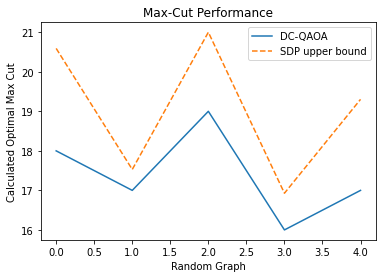

In [12]:
import matplotlib.pyplot as plt

plt.plot(value_dc_qaoa_ls, label="DC-QAOA")
plt.plot(ubound_sdp_ls, label="SDP upper bound", linestyle="--")
plt.title('Max-Cut Performance')
plt.xlabel('Random Graph')
plt.ylabel('Calculated Optimal Max Cut')
plt.legend()
plt.show()

From the line graph above, we have verified that max-cut generated by DC-QAOA is under and close to this bound.

## Applications

The Max-Cut problem belongs to quadratic unconstrained binary optimization (QUBO), which has a wide range of applications, from finding ground states for the spin glass problem to modeling NP-hard problems [5]. The Max-Cut problem itself inherits widespread usefulness.

It is extensively related to various fields, including VLSI circuit design, statistical physics. Both the problem of minimizing the number of vias subject to pin preassignments and layer preferences and the problem of finding ground states of spin glasses with exterior magnetic field in the Ising model can be reduced to the Max-Cut problem [6]. 

Also importantly, the Max-Cut problem provides a prototypical testbed for algorithmic techniques that can be applied to many interesting problems. For example, SDP relaxation of the Max-Cut problem is adopted in designing data clustering algorithms [7] and addressing the phase retrieval problem [8, 9].

More detailed investigations on the Max-Cut problem can be found in [10-12].

---

## References

[1] Akshay, V., et al. "Reachability deficits in quantum approximate optimization." [Physical Review Letters 124.9 (2020): 090504.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.090504)

[2] Li, Junde, Mahabubul Alam, and Swaroop Ghosh. "Large-scale Quantum Approximate Optimization via Divide-and-Conquer." [arXiv preprint arXiv:2102.13288 (2021).](https://arxiv.org/abs/2101.03717)

[3] Goemans, Michel X., and David P. Williamson. "Improved approximation algorithms for maximum cut and satisfiability problems using semidefinite programming." [Journal of the ACM (JACM) 42.6 (1995): 1115-1145.](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf)

[4] Burer, Samuel, and Renato DC Monteiro. "Local minima and convergence in low-rank semidefinite programming." [Mathematical Programming 103.3 (2005): 427-444.](https://link.springer.com/article/10.1007/s10107-004-0564-1)

[5] Kochenberger, Gary, et al. "The unconstrained binary quadratic programming problem: a survey." [Journal of Combinatorial Optimization 28.1 (2014): 58-81.](https://link.springer.com/article/10.1007/s10878-014-9734-0)

[6] Barahona, Francisco, et al. "An application of combinatorial optimization to statistical physics and circuit layout design." [Operations Research 36.3 (1988): 493-513.](https://www.jstor.org/stable/170992?seq=1)

[7] Poland, Jan, and Thomas Zeugmann. "Clustering pairwise distances with missing data: Maximum cuts versus normalized cuts." [International Conference on Discovery Science. Springer, Berlin, Heidelberg, 2006.](https://link.springer.com/chapter/10.1007/11893318_21)

[8] Candes, Emmanuel J., et al. "Phase retrieval via matrix completion." [SIAM review 57.2 (2015): 225-251.](https://epubs.siam.org/doi/10.1137/110848074)

[9] Waldspurger, Irene, Alexandre d’Aspremont, and Stéphane Mallat. "Phase recovery, maxcut and complex semidefinite programming." [Mathematical Programming 149.1 (2015): 47-81.](https://link.springer.com/article/10.1007/s10107-013-0738-9)

[10] Deza, Michel, and Monique Laurent. "Applications of cut polyhedra—I." [Journal of Computational and Applied Mathematics 55.2 (1994): 191-216.](https://www.sciencedirect.com/science/article/pii/0377042794900205)

[11] Deza, Michel, and Monique Laurent. "Applications of cut polyhedra—II." [Journal of Computational and Applied Mathematics 55.2 (1994): 217-247.](https://www.sciencedirect.com/science/article/pii/0377042794900213)

[12] Poljak, Svatopluk, and Zsolt Tuza. "Maximum cuts and largest bipartite subgraphs." [DIMACS Series 20 (1995): 181-244.](https://arxiv.org/pdf/1810.12144.pdf)